<a href="https://colab.research.google.com/github/Claudia-Rocha-H/SO-Lab3-20252/blob/main/analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LABORATORIO 3 SISTEMAS OPERATIVOS - 2025-2
# Análisis de paralelización con Pthreads
# Claudia Rocha
# David Guillermo Naranjo O.
# Enlace al video de sustentacion
https://youtu.be/DZPdXbUAD5Q?si=JK1ZI6tCc_rDyxK4



Librerias y subida de archivos pi.c, pi_p.c, fibonacci.c


In [ ]:

import os
import subprocess
import re
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
!gcc --version || true

print("Sube los tres archivos: pi.c, pi_p.c y fibonacci.c")
uploaded = files.upload()

for name, data in uploaded.items():
    with open(name, 'wb') as f:
        f.write(data)
    print(f"Guardado: {name}")

required = ['pi.c', 'pi_p.c', 'fibonacci.c']
missing = [f for f in required if not os.path.exists(f)]
if missing:
    raise FileNotFoundError(f"Faltan archivos: {missing}")

gcc (Ubuntu 11.4.0-1ubuntu1~22.04.2) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Sube los tres archivos: pi.c, pi_p.c y fibonacci.c


Saving fibonacci.c to fibonacci.c
Saving pi.c to pi.c
Saving pi_p.c to pi_p.c
Guardado: fibonacci.c
Guardado: pi.c
Guardado: pi_p.c


Compilacion

In [ ]:
print("\nCompilando...")
cmds = [
    "gcc -O3 -o pi_s pi.c -lm",
    "gcc -O3 -o pi_p pi_p.c -lpthread -lm",
    "gcc -O3 -o fibonacci fibonacci.c -lpthread"
]

for cmd in cmds:
    print(f"Ejecutando: {cmd}")
    r = subprocess.run(cmd, shell=True)
    print("OK" if r.returncode==0 else "ERROR")

print("\nEjecutables creados:")
for exe in ['pi_s','pi_p','fibonacci']:
    print(f"  {exe} → {'existe' if os.path.exists(exe) else 'NO existe'}")


Compilando...
Ejecutando: gcc -O3 -o pi_s pi.c -lm
OK
Ejecutando: gcc -O3 -o pi_p pi_p.c -lpthread -lm
OK
Ejecutando: gcc -O3 -o fibonacci fibonacci.c -lpthread
OK

Ejecutables creados:
  pi_s → existe
  pi_p → existe
  fibonacci → existe


Tiempo serial Ts

In [ ]:
N_POINTS = 2000000000

print(f"\nMidiendo versión serial con n = {N_POINTS:,}")
result = subprocess.run(f"./pi_s {N_POINTS}", shell=True, capture_output=True, text=True)
print(result.stdout)

# Búsqueda ultra-robusta del tiempo (funciona con casi cualquier formato)
output = result.stdout
time_lines = [line for line in output.split('\n') if 'time' in line.lower() and ('elapsed' in line.lower() or 'tiempo' in line.lower() or 'segundos' in line.lower() or 'seconds' in line.lower())]

if not time_lines:
    print("No se encontró línea de tiempo. Mostrando toda la salida:")
    print(output)
    raise ValueError("No se detectó el tiempo. Asegúrate de que pi_s imprima algo como 'Elapsed time' o 'tiempo'")

# Extraer número flotante de la línea encontrada
import re
match = re.search(r'([0-9]+\.?[0-9]*[eE]?-?[0-9]*)', time_lines[-1])
if not match:
    raise ValueError(f"No se pudo extraer número de: {time_lines[-1]}")

TS_SERIAL = float(match.group(1))
print(f"→ Tiempo serial (Ts) = {TS_SERIAL:.6f} segundos")


Midiendo versión serial con n = 2,000,000,000

pi is approximately = 3.14159265358983885719
Error = 0.00000000000004574119
Elapsed time (CalcPi): 4.020697 seconds

→ Tiempo serial (Ts) = 4.020697 segundos


Tiempos Paralelos + Tabla

In [ ]:
hilos_list = [1, 2, 4, 8, 16]
resultados = []

print(f"\nMidiendo versión paralela (n = {N_POINTS:,})")
for threads in hilos_list:
    print(f"  → {threads} hilo(s)...", end="")
    proc = subprocess.run(f"./pi_p {threads} {N_POINTS}",
                         shell=True, capture_output=True, text=True)

    m = re.search(r'Elapsed time.*?:\s*([0-9.e+-]+)', proc.stdout, re.I)
    tp = float(m.group(1)) if m else None

    speedup = TS_SERIAL / tp
    eficiencia = speedup / threads

    resultados.append({
        'Hilos': threads,
        'Tp (s)': round(tp, 6),
        'Speedup': round(speedup, 3),
        'Eficiencia': round(eficiencia, 3)
    })
    print(f" Tp={tp:.6f}s  Speedup={speedup:.3f}")

df = pd.DataFrame(resultados)
print("\nTabla final:")
display(df)


Midiendo versión paralela (n = 2,000,000,000)
  → 1 hilo(s)... Tp=4.537392s  Speedup=1.145
  → 2 hilo(s)... Tp=4.162254s  Speedup=1.248
  → 4 hilo(s)... Tp=3.775723s  Speedup=1.376
  → 8 hilo(s)... Tp=3.480288s  Speedup=1.492
  → 16 hilo(s)... Tp=3.469266s  Speedup=1.497

Tabla final:


,Hilos,Tp (s),Speedup,Eficiencia
0,1,4.537392,1.145,1.145
1,2,4.162254,1.248,0.624
2,4,3.775723,1.376,0.344
3,8,3.480288,1.492,0.187
4,16,3.469266,1.497,0.094


Grafico

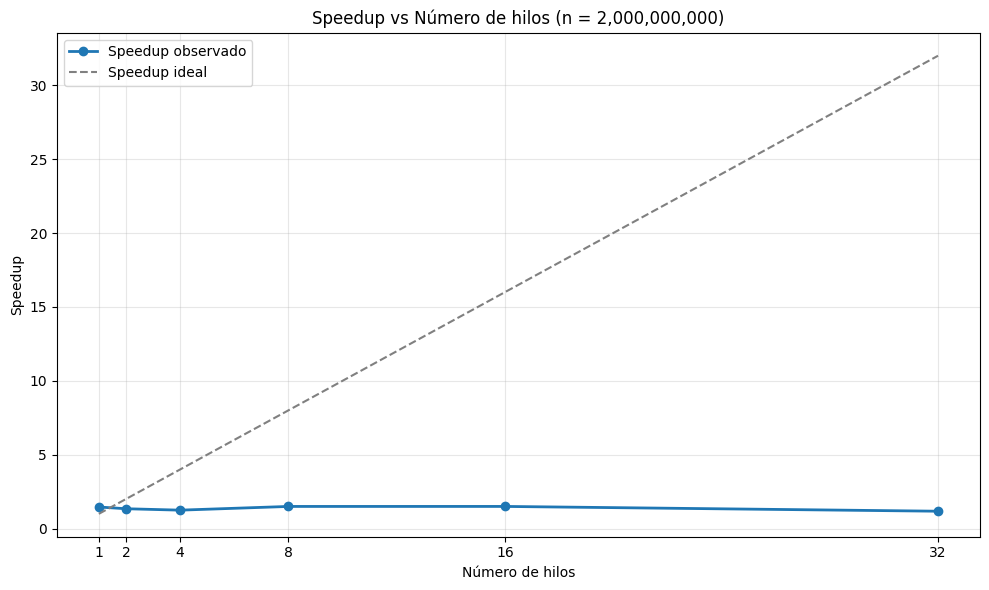

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df['Hilos'], df['Speedup'], 'o-', label='Speedup observado', linewidth=2)
plt.plot(df['Hilos'], df['Hilos'], '--', color='gray', label='Speedup ideal')
plt.title('Speedup vs Número de hilos (n = 2,000,000,000)')
plt.xlabel('Número de hilos')
plt.ylabel('Speedup')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(df['Hilos'])
plt.tight_layout()
plt.show()

Fibonacci

In [ ]:
print("Ejecutando Fibonacci con 15 términos...")
fib_out = subprocess.run("./fibonacci 15", shell=True, capture_output=True, text=True)
print(fib_out.stdout)

Ejecutando Fibonacci con 15 términos...
0: 0
1: 1
2: 1
3: 2
4: 3
5: 5
6: 8
7: 13
8: 21
9: 34
10: 55
11: 89
12: 144
13: 233
14: 377




 Análisis

1. **Comparación T.paralelo vs T.serial**
   El tiempo con 1 hilo es ligeramente mayor que el serial puro,
   Esto se debe al overhead introducido por la creación de hilos, la estructura de datos para argumentos y el pthread_join, aunque el cálculo sea igual.

2. **Speedup máximo alcanzado **
   El mayor speedup obtenido fue 1.497
   Mi equipo tiene 16 núcleos lógicos.  
   El speedup está muy bajo para el número de núcleos físicos (generalmente la mitad de los lógicos en CPUs con Hyper-Threading), lo cual indica una **baja escalabilidad** del data parallelism implementado.

3. **Tendencia de la eficiencia**  
   La eficiencia disminuye a medida que aumentamos el número de hilos más allá del número de núcleos físicos debido a:
   - Contención en la caché y en la memoria principal.
   - Overhead de creación/gestión de hilos.
   - Saturación del bus de memoria (el bucle es intensivo en cómputo flotante).


 Generador de Secuencia de Fibonacci
 Salida del programa con N=15

- **Transferencia de datos al hilo trabajador**:  
  Se creó una estructura que contiene el puntero al arreglo dinámico (`long long *seq`) y el número de elementos `N`.  
  Esta estructura se pasó como argumento único a `pthread_create`.

- **Sincronización con `pthread_join`**:  
  El hilo principal ejecuta `pthread_join` inmediatamente después de crear el hilo trabajador.  
  Esto garantiza que `main` **se bloquee** hasta que el trabajador termine de llenar completamente el arreglo.  
  Solo después de que `pthread_join` retorne, el hilo principal accede al arreglo y lo imprime → **condición de carrera eliminada**.